# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1) -->
<img src="https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
from math import log, e
def entropy(k1, k2):
    k = k1 + k2
    return round((-k1/k)*log(k1/k,e)+(-k2/k)*log(k2/k,e),2)

entropy(8,2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def gini(n1,n2):
    p1 = n1/(n1+n2)
    p2 = n2/(n1+n2)
    h = p1*(1-p1)+p2*(1-p2)
    h_l = (n1/n1)*(1-(n1/n1))+(0/n1)*(1-(0/n1))
    h_r = (n2/n2)*(1-(n2/n2))+(0/n2)*(1-(0/n2))
    return h-p1*h_l-p2*h_r
gini(8,2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
values_in_leaf =  [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(sum(values_in_leaf)/len(values_in_leaf))
# усредняем значения целевой переменной, так как решается задача регрессии

40.6


## Часть 2: Решающие деревья

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [8]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    ginis = []
    thresholds = np.unique(feature_vector)

    if feature_type == "real":
        thresholds = (thresholds[:-1] + thresholds[1:]) / 2

    for t in thresholds:
        if feature_type == "real":
            n = (feature_vector <= t)
        else:
            n = (feature_vector == t)

        Hleft = feature_vector[n]
        yleft = target_vector[n]
        Hright = feature_vector[~n]
        yright = target_vector[~n]

        if task == "classification":
            err = gini(feature_vector) - (len(Hleft) /len(feature_vector)*gini(Hleft)) - (len(Hright) /len(feature_vector)*gini(Hright))
        else:
            err = feature_vector.var() - (len(Hleft) / len(feature_vector) * yleft.var()) - (len(Hright) / len(feature_vector) * yright.var())
        ginis.append(err)

    ginis = np.nan_to_num(ginis, nan=float("-inf"))
    threshold_best = thresholds[np.argmax(ginis)]
    gini_best = ginis[np.argmax(ginis)]

    return thresholds, ginis, threshold_best, gini_best
    pass

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [ ]:
print(data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [ ]:
thresholds, variances, threshold_best, variance_best = find_best_split(X["MedInc"], y, task="regression", feature_type="real")

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

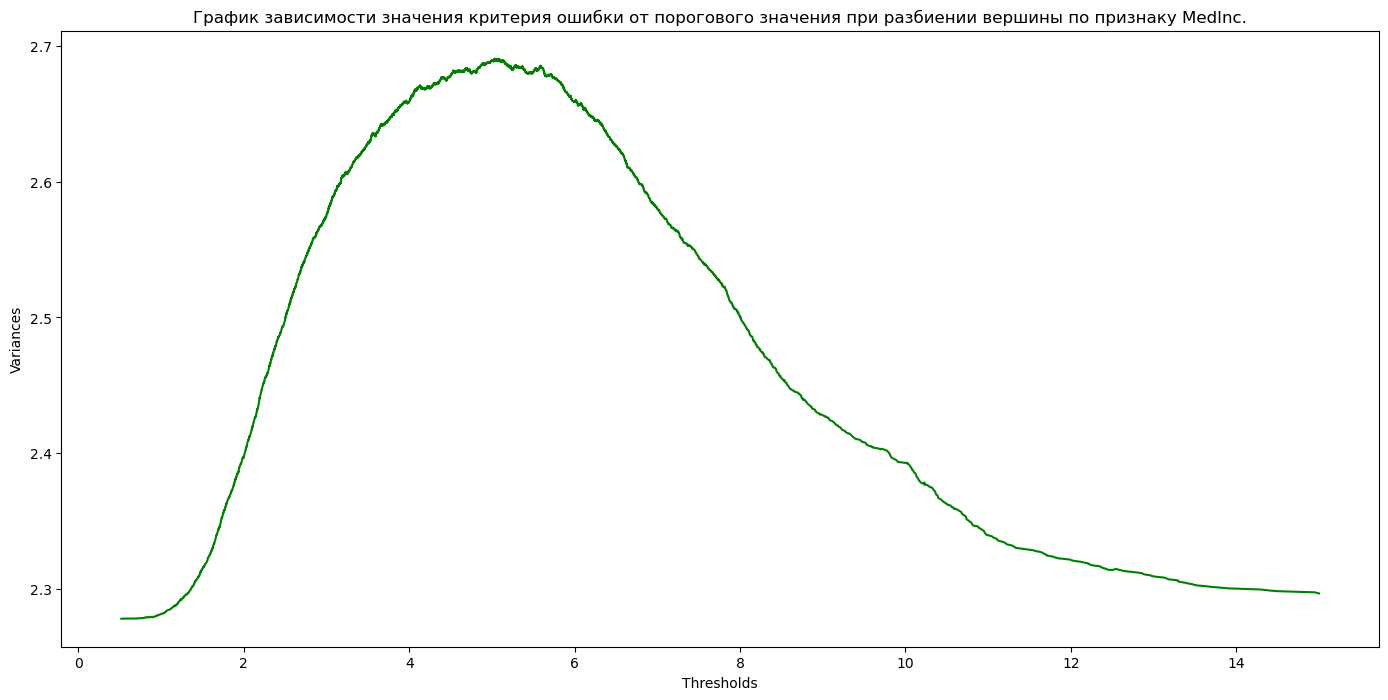

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(thresholds, variances, color = 'green')
plt.title('График зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку MedInc.')
plt.xlabel('Thresholds')
plt.ylabel('Variances')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [ ]:
(find_best_split(X["MedInc"], y, task="regression", feature_type="real"))[2]

5.03515

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [5]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2023/homeworks/hw07-trees/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Посмотрим на распределение целевой переменной

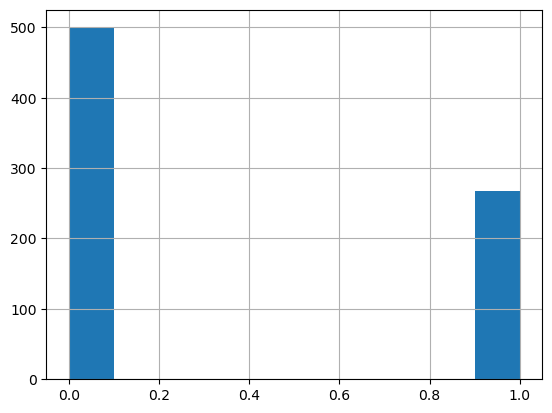

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.model_selection import train_test_split
y = data['Outcome']
X = data.drop(['Outcome'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 10)
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
491,2,89,90,30,0,33.5,0.292,42
69,4,146,85,27,100,28.9,0.189,27
667,10,111,70,27,0,27.5,0.141,40
566,1,99,72,30,18,38.6,0.412,21
97,1,71,48,18,76,20.4,0.323,22
...,...,...,...,...,...,...,...,...
369,1,133,102,28,140,32.8,0.234,45
320,4,129,60,12,231,27.5,0.527,31
527,3,116,74,15,105,26.3,0.107,24
125,1,88,30,42,99,55.0,0.496,26


In [ ]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state = 10)
X_train_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
388,5,144,82,26,285,32.0,0.452,58
107,4,144,58,28,140,29.5,0.287,37
597,1,89,24,19,25,27.8,0.559,21
648,11,136,84,35,130,28.3,0.260,42
471,0,137,70,38,0,33.2,0.170,22
...,...,...,...,...,...,...,...,...
376,0,98,82,15,84,25.2,0.299,22
127,1,118,58,36,94,33.3,0.261,23
8,2,197,70,45,543,30.5,0.158,53
673,3,123,100,35,240,57.3,0.880,22


In [ ]:
# проверим пропорции получившегося разбиения
print(f'Обучающая-обучающая выборка составляет {round((X_train_train.shape[0]/X.shape[0])*100)}% от исходного датасета.')
print(f'Обучающая-валидационная выборка составляет {round(X_train_val.shape[0]/X.shape[0]*100)}% от исходного датасета.')
print(f'Тестовая выборка составляет {round(X_test.shape[0]/X.shape[0]*100)}% от исходного датасета.')

Обучающая-обучающая выборка составляет 49% от исходного датасета.
Обучающая-валидационная выборка составляет 21% от исходного датасета.
Тестовая выборка составляет 30% от исходного датасета.


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
# max_depth - максимальная глубина дерева
# min_samples_leaf - минимальное число объектов в вершине дерева, необходимое для того, чтобы она стала листовой

max_depth_list = [3, 5, 10, 30, 50]
min_samples_leaf_list = [1, 5, 10, 15, 25]

for max_depth in max_depth_list:
    for min_samples_leaf in min_samples_leaf_list:
        dt = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=10)
        dt.fit(X_train_train, y_train_train)
        pred = dt.predict(X_train_val)
        print(f'Глубина дерева: {max_depth}')
        print(f'Минимальное число объектов в листе: {min_samples_leaf}')
        print("F1 score:", f1_score(y_train_val, pred))
        print("********************")

Глубина дерева: 3
Минимальное число объектов в листе: 1
F1 score: 0.4222222222222222
********************
Глубина дерева: 3
Минимальное число объектов в листе: 5
F1 score: 0.367816091954023
********************
Глубина дерева: 3
Минимальное число объектов в листе: 10
F1 score: 0.47311827956989244
********************
Глубина дерева: 3
Минимальное число объектов в листе: 15
F1 score: 0.47311827956989244
********************
Глубина дерева: 3
Минимальное число объектов в листе: 25
F1 score: 0.47311827956989244
********************
Глубина дерева: 5
Минимальное число объектов в листе: 1
F1 score: 0.59375
********************
Глубина дерева: 5
Минимальное число объектов в листе: 5
F1 score: 0.5794392523364487
********************
Глубина дерева: 5
Минимальное число объектов в листе: 10
F1 score: 0.603448275862069
********************
Глубина дерева: 5
Минимальное число объектов в листе: 15
F1 score: 0.6181818181818182
********************
Глубина дерева: 5
Минимальное число объектов в лист

**Пара значений, которая даёт наилучшее качество на обучающей-валидационной выборке:**

Глубина дерева: 10

Минимальное число объектов в листе: 15

F1 score: 0.6721311475409836

In [ ]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=15, random_state=10)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, dt_pred)}')
print(f'Precision: {precision_score(y_test, dt_pred)}')
print(f'Recall: {recall_score(y_test, dt_pred)}')
print(f'AUC-ROC: {roc_auc_score(y_test, dt_pred)}')

Accuracy: 0.7229437229437229
Precision: 0.6455696202531646
Recall: 0.5862068965517241
AUC-ROC: 0.6958812260536399


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
bagg = BaggingClassifier(n_estimators = 50, random_state = 10)
bagg.fit(X_train, y_train)
bagg_pred = bagg.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, bagg_pred)}')
print(f'Precision: {precision_score(y_test, bagg_pred)}')
print(f'Recall: {recall_score(y_test, bagg_pred)}')
print(f'AUC-ROC: {roc_auc_score(y_test, bagg_pred)}')

Accuracy: 0.7705627705627706
Precision: 0.7931034482758621
Recall: 0.5287356321839081
AUC-ROC: 0.7227011494252873


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

max_depth_list = [3, 5, 15, 20]
min_samples_split_list = [5, 10, 15, 18]

for depth in max_depth_list:
    for min_samples_split in min_samples_split_list:
        rf = RandomForestClassifier(n_estimators=50, max_depth = depth,
                                    min_samples_split = min_samples_split, random_state = 10)
        score = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
        print(f'max_depth: {depth}')
        print(f'min_samples_split: {min_samples_split}')
        print(f'F1 score: {score.mean()}')
        print('******')

max_depth: 3
min_samples_split: 5
F1 score: 0.5882836829425935
******
max_depth: 3
min_samples_split: 10
F1 score: 0.5853579107875152
******
max_depth: 3
min_samples_split: 15
F1 score: 0.5887289771160739
******
max_depth: 3
min_samples_split: 18
F1 score: 0.579421732272076
******
max_depth: 5
min_samples_split: 5
F1 score: 0.5713282414307004
******
max_depth: 5
min_samples_split: 10
F1 score: 0.6006185107680622
******
max_depth: 5
min_samples_split: 15
F1 score: 0.5949643928609695
******
max_depth: 5
min_samples_split: 18
F1 score: 0.5890191653075826
******
max_depth: 15
min_samples_split: 5
F1 score: 0.6181328745880984
******
max_depth: 15
min_samples_split: 10
F1 score: 0.606100631162054
******
max_depth: 15
min_samples_split: 15
F1 score: 0.6050048403832142
******
max_depth: 15
min_samples_split: 18
F1 score: 0.617170748370822
******
max_depth: 20
min_samples_split: 5
F1 score: 0.6278994859048711
******
max_depth: 20
min_samples_split: 10
F1 score: 0.606100631162054
******
max_dept

Наулучшее среднее качество модели мы наблюдаем при параметрах:

**max_depth: 20**

**min_samples_split: 5**

F1 score: 0.6278994859048711

In [ ]:
rf = RandomForestClassifier(n_estimators=50, max_depth =20, min_samples_split = 5, random_state = 10)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, pred_rf)}')
print(f'Precision: {precision_score(y_test, pred_rf)}')
print(f'Recall: {recall_score(y_test, pred_rf)}')
print(f'AUC-ROC: {roc_auc_score(y_test, pred_rf)}')

Accuracy: 0.7445887445887446
Precision: 0.75
Recall: 0.4827586206896552
AUC-ROC: 0.6927681992337166


In [ ]:
tabl = pd.DataFrame(np.matrix([[0.7229437229437229, 0.6455696202531646, 0.5862068965517241, 0.6958812260536399],
                             [0.7705627705627706, 0.7931034482758621, 0.5287356321839081, 0.7227011494252873],
                             [0.7445887445887446, 0.75, 0.4827586206896552, 0.6927681992337166]]))
tabl = tabl.rename(columns= {0:"Accuracy", 1:"Precision", 2:"Recall", 3:"AUC-ROC"})
tabl
# 0 - DecisionTreeClassifier
# 1 - BaggingClassifier
# 2 - RandomForestClassifier

,Accuracy,Precision,Recall,AUC-ROC
0,0.722944,0.645570,0.586207,0.695881
1,0.770563,0.793103,0.528736,0.722701
2,0.744589,0.750000,0.482759,0.692768


**ВЫВОД:**

Какая из трёх построенных моделей показала себя лучше?
По подобранным гиперпараметрам лучшей моделью оказалась BaggingClassifier, заметим по данным построенной таблицы (tabl) именно у этой модели наибольший показатель AUC-ROC, то есть эта модель больше похожа на "идеальный" классификатор.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

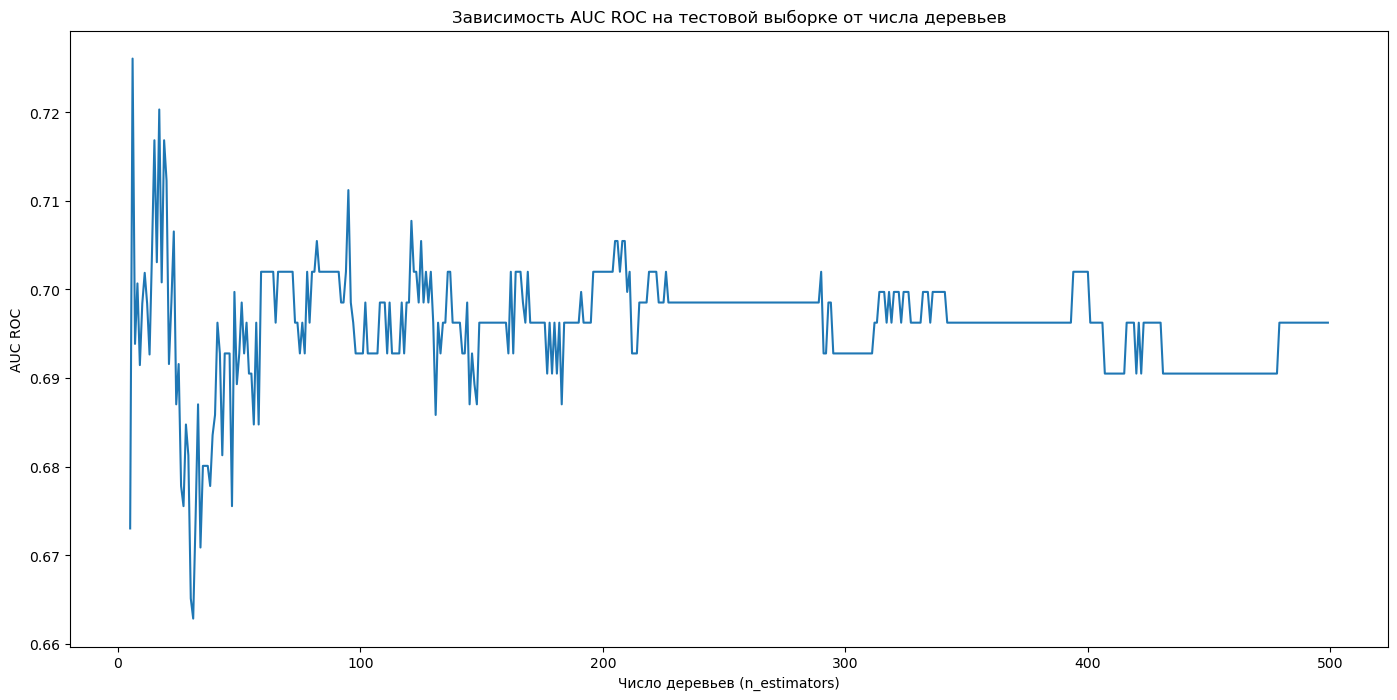

In [ ]:
auc_roc_values  = []
for i in range(5, 500):
    rf = RandomForestClassifier(n_estimators = i, max_depth =20, min_samples_split = 5, random_state = 10)
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    auc_roc_values.append(roc_auc_score(y_test, pred_rf))

plt.figure(figsize = (17,8))
plt.plot(range(5, 500), auc_roc_values)
plt.title('Зависимость AUC ROC на тестовой выборке от числа деревьев')
plt.xlabel('Число деревьев (n_estimators)')
plt.ylabel('AUC ROC')
plt.show()

**ВЫВОД:**

По построенному графику зависимости AUC ROC на тестовой выборке от числа деревьев (n_estimators) для случайного леса можно заметить, что по мере увеличения количества деревьев величина AUC ROC колеблется в конкретном коридоре значений. Предполагаю, что при дальнейшем увеличении n_estimators на данном графике (>500), график выйдет на асимпототу (у случайного леса аналогичная ситуация наблюдается при увеличении числа деревьев и изменении ошибки относительно этого, то есть с определенного N ошибка выходит на асимпототу).



**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [ ]:
rf_best = RandomForestClassifier(n_estimators=50, max_depth =20, min_samples_split = 5, random_state = 10)
rf_best.fit(X_train, y_train)
pred_rf_best = rf_best.predict(X_test)

In [ ]:
importances = rf_best.feature_importances_
importances

array([0.08430374, 0.28038106, 0.0793583 , 0.06169444, 0.07220229,
       0.17485902, 0.10668346, 0.14051767])

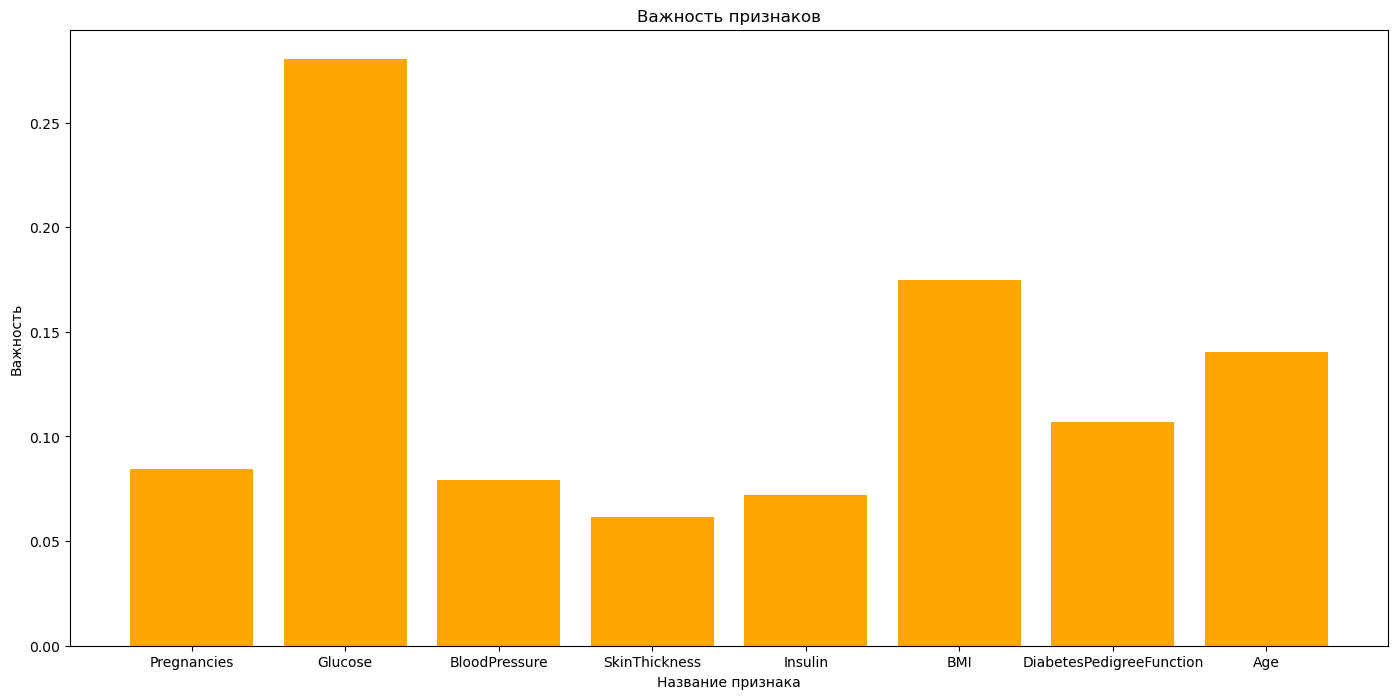

In [ ]:
importances = rf_best.feature_importances_
fig = plt.figure(figsize=(17, 8))

plt.bar(X.columns, importances, color = 'orange')
plt.title("Важность признаков")
plt.xlabel('Название признака')
plt.ylabel('Важность')
plt.show()
# самым важным признаком для определения диабета оказался Glucose